In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Data Augmentation-XrayImg

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Data Augmentation-XrayImg


# 0. Import Libs

In [2]:
import torch
import glob
from torchvision import transforms
import matplotlib.pyplot as plt 
import cv2
import json
import os
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models
import numpy as np
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from matplotlib import patches
from tqdm.notebook import tqdm

# 1. Some configs

In [3]:
data_train_path = './original/dataDetect_train'
data_test_path = './original/dataDetect_test'
train_data_json='./original/train_data.json'
test_data_json='./original/test_data.json'
save_train_mask_folder='./original/mask_train'
save_test_mask_folder='./original/mask_test'
device='cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE=4 # CUDA out of memory :(
EPOCH_N=10
CLASS_N=2
WIDTH=300
HEIGHT=300

# 2. Deeplabv3_resnet101 for Semantic Seg

In [ ]:
model = models.segmentation.deeplabv3_resnet101(pretrained=True,progress=True)
model.classifier = DeepLabHead(2048, 1)
model.to(device)

In [5]:
model.load_state_dict(torch.load("./model.pth"))

<All keys matched successfully>

In [6]:

def read_json(path):
  with open(path,'r') as f:
    data = json.load(f)
  return data


def write_json(dic,path):
  with open(path,'w') as f:
    json.dump(dic,f,indent=4)


def get_anno(txt_path):
    annos=[]
    with open(txt_path) as f:
      for line in f.readlines():
        anno=line[:-1].split(" ")
        anno = [float(num) for num in anno]
        annos.append(anno[1:])
    return annos


def get_offset(annos,image): # for single image
  new_annos=[]
  for annotation in annos:
    bbox = [annotation[0] * image.shape[1], annotation[1] * image.shape[0], 
            annotation[2] * image.shape[1], annotation[3] * image.shape[0]]
    new_annos.append(bbox)
  return new_annos


def get_path(data_path):
  img_paths = glob.glob(os.path.join(data_path,"*.png"))
  dic={}
  for img_path in img_paths:
    txt_path = img_path.replace('.png','.txt')
    dic[img_path]=get_anno(txt_path)
  return dic


def my_draw(img_path,anno):
  image=cv2.imread(img_path)
  print(image.shape)
  bboxs=get_offset(anno,image)
  for bbox in bboxs:
    cv2.rectangle(image, (int(bbox[0] - bbox[2] / 2), int(bbox[1] - bbox[3] / 2)), (int(bbox[0] + bbox[2] / 2), int(bbox[1] + bbox[3] / 2)), (225, 0, 0), 2)
  plt.figure(figsize = (10, 10))
  plt.imshow(image)
  plt.show()


def remove_background(img,mask):
  img=np.transpose(img, (2, 0, 1))
  for channel in img:
    for i in range(len(channel)):
      for j in range(len(channel[i])):
        if mask[i][j]==0:
          channel[i][j]=0
  
  return np.transpose(img, (1, 2, 0))


def equalize_clahe_color(img):
    cla = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(18, 18))
    channels = cv2.split(img)
    eq_channels = []
    for ch in channels:
        eq_channels.append(cla.apply(ch))
    eq_image = cv2.merge(eq_channels)
    return eq_image

def get_mask(img_path,thres):
  img_=cv2.imread(img_path)
  trans=transforms.Compose([transforms.ToTensor(),transforms.Resize((HEIGHT,WIDTH))])
  img=trans(img_)
  img_=cv2.resize(img_,(HEIGHT,WIDTH))
  img=img.reshape(1,img.shape[0],img.shape[1],img.shape[2])

  with torch.no_grad():
      out = model.eval().cpu()(img)['out'][0]
      out=torch.sigmoid(out)
  out[out>thres]=255
  out[out<=thres]=0
  return out[0]


def save_mask(save_folder,data_json,thres):
  dic=read_json(data_json)
  img_paths=list(dic.keys())
  if not os.path.isdir(save_folder):
    os.mkdir(save_folder)
  save_folder_thres=os.path.join(save_folder,'_%f'%thres)
  if not os.path.isdir(save_folder_thres):
    os.mkdir(save_folder_thres)
  for path in img_paths:
    mask=get_mask(path,thres).numpy()
    cv2.imwrite(os.path.join(save_folder_thres,path.split('/')[-1]),mask)

In [7]:
# save_mask(save_test_mask_folder,test_data_json,thres=0.16)
# save_mask(save_train_mask_folder,train_data_json,thres=0.16)

In [8]:
# dic_train=get_path(data_train_path)
# dic_test=get_path(data_test_path)
# write_json(dic_train,train_data_json)
# write_json(dic_test,test_data_json)

In [9]:
test_dic=read_json(test_data_json)

In [10]:
img_paths=list(test_dic.keys())
anno_paths=list(test_dic.values())

(512, 420, 3)


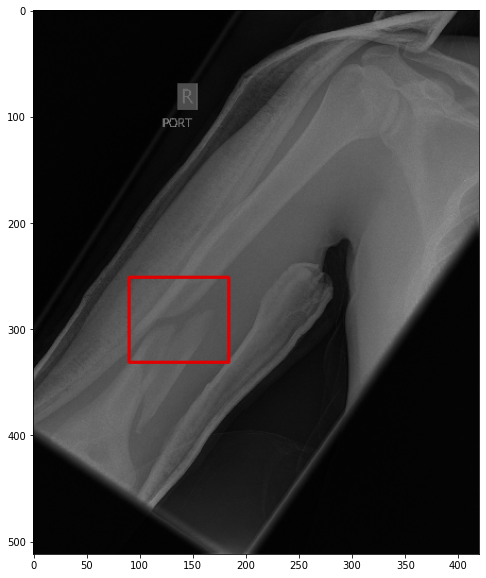

In [11]:
idx= 4
my_draw(img_paths[idx],anno_paths[idx])

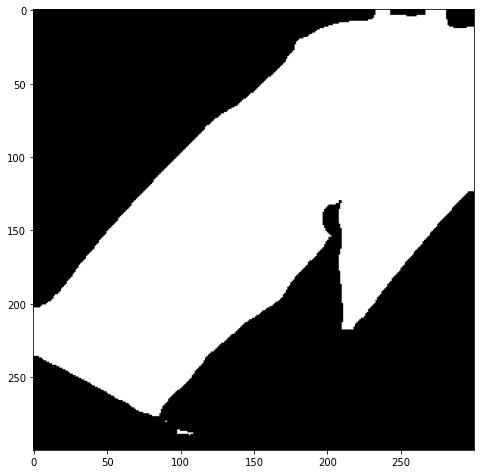

In [12]:
mask_test=get_mask(img_paths[idx],thres=0.15)
plt.figure(figsize=(8.1,8.1))
plt.imshow(mask_test,cmap='gray')
plt.show()

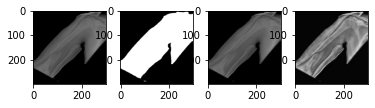

In [13]:
img_=cv2.imread(img_paths[idx])
trans=transforms.Compose([transforms.ToTensor(),transforms.Resize((HEIGHT,WIDTH))])
img=trans(img_)
img_=cv2.resize(img_,(HEIGHT,WIDTH))

img=img.reshape(1,img.shape[0],img.shape[1],img.shape[2])

with torch.no_grad():
    out = model.eval().cpu()(img)['out'][0]
    out=torch.sigmoid(out)

out[out>0.15]=255
out[out<=0.15]=0
img=img[0].permute(1,2,0)
new_re=remove_background(img_,out[0].numpy())
clahe_img=equalize_clahe_color(new_re)
plt.subplot(1,4,1)
plt.imshow(img_)
plt.subplot(1,4,2)
plt.imshow(out[0], cmap='gray')
plt.subplot(1,4,3)
plt.imshow(new_re)
plt.subplot(1,4,4)
plt.imshow(clahe_img)
plt.show()

# 3. FasterRcnn Object Detection

In [14]:
class XrayImgDataset(Dataset):
  def __init__(self,json_file,phase,thresh=0.3):
    self.data=read_json(json_file)
    self.img_paths=list(self.data.keys())
    self.bbxs=list(self.data.values())
    self.phase=phase
    self.thresh=thresh
    self.transforms=transforms.Compose([transforms.ToTensor(),transforms.Resize((HEIGHT,WIDTH))])

  def get_mask(self,img_):
    img_=cv2.resize(img_,(HEIGHT,WIDTH))
    img=trans(img_)
    img=img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
    with torch.no_grad():
        out = model.eval().cpu()(img)['out'][0]
        out=torch.sigmoid(out)
    img=img[0].permute(1,2,0)
    out[out>self.thresh]=1
    out[out<=self.thresh]=0
    img=remove_background(img_,out[0].numpy())
    img=equalize_clahe_color(img)
    return img

  def convert_offsets(self,bbx,img):
    bboxs=get_offset(bbx,img)
    new_bbx=[[int(bbox[0] - bbox[2] / 2), int(bbox[1] - bbox[3] / 2),int(bbox[0] + bbox[2] / 2),int(bbox[1] + bbox[3] / 2)] for bbox in bboxs]
    return new_bbx

    
  def __getitem__(self,idx):
    img_path=self.img_paths[idx]
    img_=cv2.imread(img_path)
    bbxs=self.convert_offsets(self.bbxs[idx],img_)
    img=self.get_mask(img_)

    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB

    for bbx in bbxs:
      bbx[0]=bbx[0]/img_.shape[1]*WIDTH
      bbx[1]=bbx[1]/img_.shape[0]*HEIGHT
      bbx[2]=bbx[2]/img_.shape[1]*WIDTH
      bbx[3]=bbx[3]/img_.shape[0]*HEIGHT

    img=img.astype(float)
    img=self.transforms(img)
    img=img/255
    bbxs=torch.FloatTensor(bbxs)
    targets={}
    targets['boxes']=bbxs
    targets['labels']=torch.ones(bbxs.shape[0]).long()
    return img,targets

  def __len__(self):
    return len(self.data)


In [15]:
train_data=XrayImgDataset(train_data_json,'train')
train_dataloader = torch.utils.data.DataLoader(
   train_data,
   batch_size=BATCH_SIZE,
   num_workers=2,
   shuffle=True,
   collate_fn=lambda x: list(zip(*x)),
   )


val_data=XrayImgDataset(test_data_json,'val')
val_dataloader = torch.utils.data.DataLoader(
   val_data,
   batch_size=2,
   num_workers=2,
   shuffle=True,
   collate_fn=lambda x: list(zip(*x)),
   )

In [ ]:
model_faster=torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features=model_faster.roi_heads.box_predictor.cls_score.in_features
print(in_features)
model_faster.roi_heads.box_predictor=FastRCNNPredictor(in_features,CLASS_N)
model_faster=model_faster.to(device)
params=[p for p in model_faster.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(model_faster.parameters(), lr=3e-4, weight_decay=5e-4)
print(list(model_faster.children()))

In [ ]:
model_faster.load_state_dict(torch.load("./faster_e2e.pth")
best_point=9999
for epoch in range(EPOCH_N):
	print("Training...")
	train_loss=0
	val_loss=0
	for imgs,targets in tqdm(train_dataloader):
		model_faster.train()
		model_faster=model_faster.double()
		optimizer.zero_grad()
		imgs=list(img.to(device) for img in imgs)
		targets=[{k:v.to(device) for k,v in t.items()} for t in targets]
		loss_dict=model_faster(imgs,targets)
		losses=sum(loss for loss in loss_dict.values())   	
		losses.backward()
		optimizer.step()
		train_loss+=losses.item()

	for imgs,targets in tqdm(val_dataloader):
		model_faster.eval()
		imgs=list(img.to(device) for img in imgs)
		targets=[{k:v.to(device) for k,v in t.items()} for t in targets]
		loss_dict_val=model_faster(imgs,targets)
		losses_val=sum(loss for loss in loss_dict.values())
		val_loss+=losses_val.item()
		if losses_val.item()<best_point:
			best_point=losses_val.item()
			torch.save(model_faster.state_dict(), "./faster_e2e.pth")

		#print(losses.item())

	print("------------------------->", train_loss,val_loss)

In [22]:
model_faster.load_state_dict(torch.load("./faster_e2e.pth"))

<All keys matched successfully>

In [32]:
item=iter(train_dataloader)
images,targets=item.next()

In [33]:

def view(images,labels,k,std=1,mean=0):

  figure=plt.figure(figsize=(15,15))
  images=list(images)
  labels=list(labels)
  for i in range(k):
    out=torchvision.utils.make_grid(images[i])
    inp=out.cpu().numpy().transpose((1,2,0))
    inp=np.array(std)*inp+np.array(mean)
    inp=np.clip(inp,0,1)  
    ax = figure.add_subplot(2,2, i + 1)
    ax.imshow(images[i].cpu().numpy().transpose((1,2,0)))
    l=labels[i]['boxes'].cpu().numpy()
    l[:,2]=l[:,2]-l[:,0]
    l[:,3]=l[:,3]-l[:,1]
    for j in range(len(l)):
      ax.add_patch(patches.Rectangle((l[j][0],l[j][1]),l[j][2],l[j][3],linewidth=2,edgecolor='w',facecolor='none'))

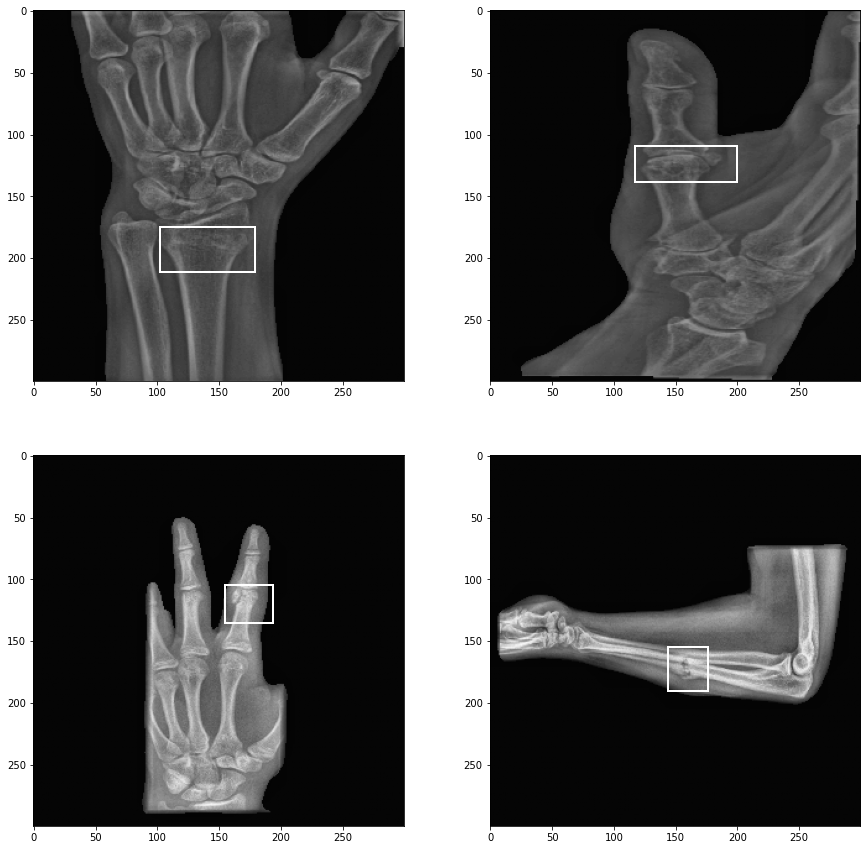

In [34]:
view(images,targets,4) # truth

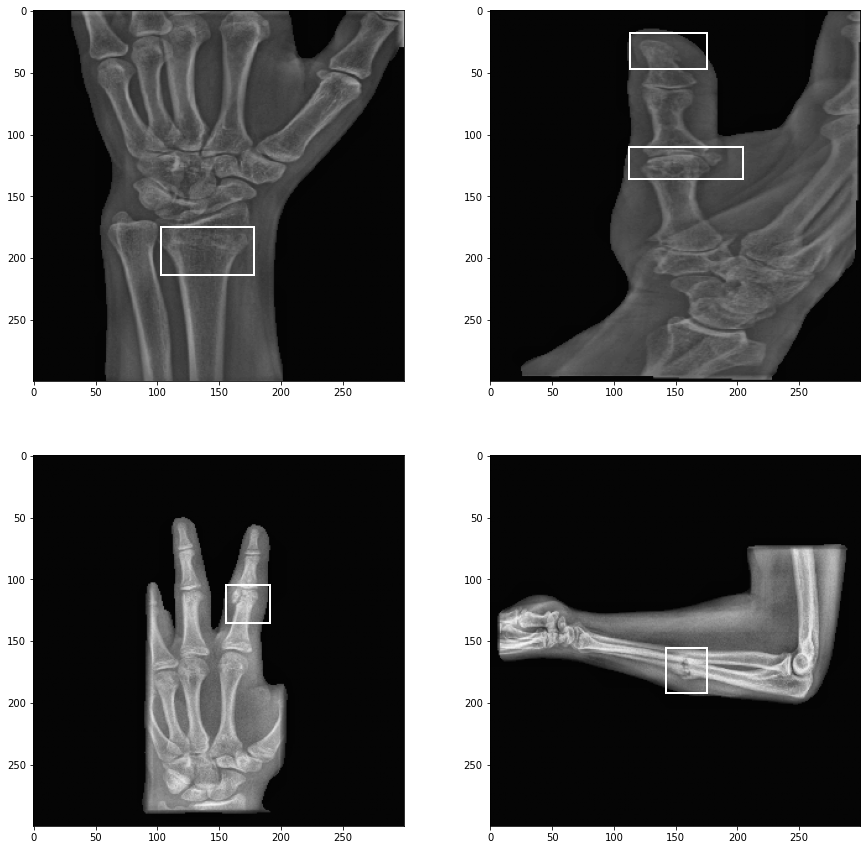

In [35]:
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model_faster.eval()
model_faster=model_faster.double()
output=model_faster(images)
# predict :))
with torch.no_grad():
    view(images,output,4)